In [23]:
%pwd

'/Users/pw/Downloads/cats_and_dogs sound/cats_dogs/train'

In [24]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from signal_processor import SignalProcessor

sp = SignalProcessor()
cat_dir = 'cat'
dog_dir = 'dog'

In [2]:
cat_files = sorted([f for f in os.listdir(cat_dir) if f.endswith('.wav')])
dog_files = sorted([f for f in os.listdir(dog_dir) if f.endswith('.wav')])
print(f'Number of cat files: {len(cat_files)}')
print(f'Number of dog files: {len(dog_files)}')

Number of cat files: 125
Number of dog files: 85


In [3]:
def get_duration(path):
    fs, data = wavfile.read(path)
    return data.shape[0] / fs

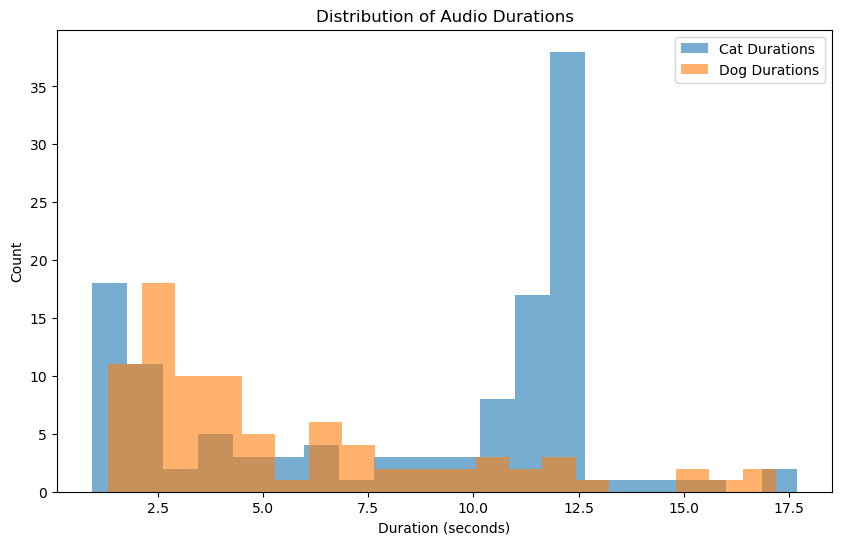

In [4]:
cat_durations = [get_duration(os.path.join(cat_dir, f)) for f in cat_files]
dog_durations = [get_duration(os.path.join(dog_dir, f)) for f in dog_files]

plt.figure(figsize=(10, 6))
plt.hist(cat_durations, bins=20, alpha=0.6, label='Cat Durations')
plt.hist(dog_durations, bins=20, alpha=0.6, label='Dog Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.title('Distribution of Audio Durations')
plt.legend()
plt.show()

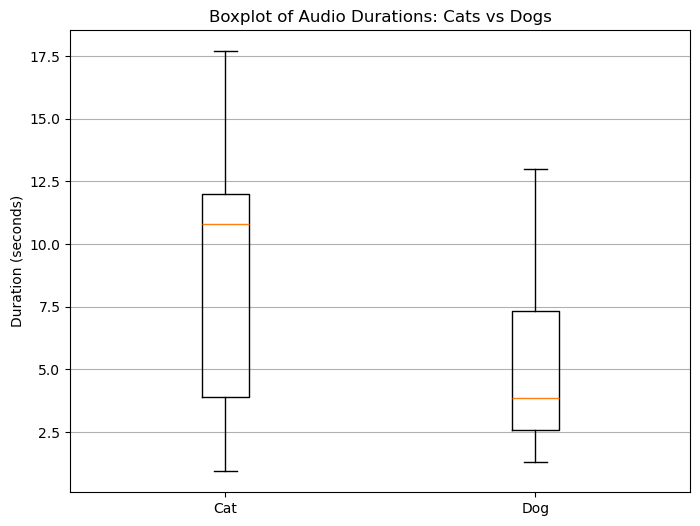

In [5]:
plt.figure(figsize=(8, 6))
plt.boxplot([cat_durations, dog_durations], tick_labels=['Cat', 'Dog'], showfliers=False)
plt.ylabel('Duration (seconds)')
plt.title('Boxplot of Audio Durations: Cats vs Dogs')
plt.grid(axis='y')
plt.show()

In [26]:
cat_sample = os.path.join(cat_dir, random.choice(cat_files))
dog_sample = os.path.join(dog_dir, random.choice(dog_files))

In [27]:
from IPython.display import Audio, display
display(Audio(cat_sample, autoplay=True))

In [28]:
display(Audio(dog_sample, autoplay=True))

In [29]:
fs_cat, data_cat = wavfile.read(cat_sample)
if data_cat.ndim > 1:
    data_cat = data_cat[:, 0]
dt_cat = 1 / fs_cat

fs_dog, data_dog = wavfile.read(dog_sample)
if data_dog.ndim > 1:
    data_dog = data_dog[:, 0]
dt_dog = 1 / fs_dog

freq_cat, Y_cat = sp.compute_fft(data_cat, dt_cat)
freq_dog, Y_dog = sp.compute_fft(data_dog, dt_dog)

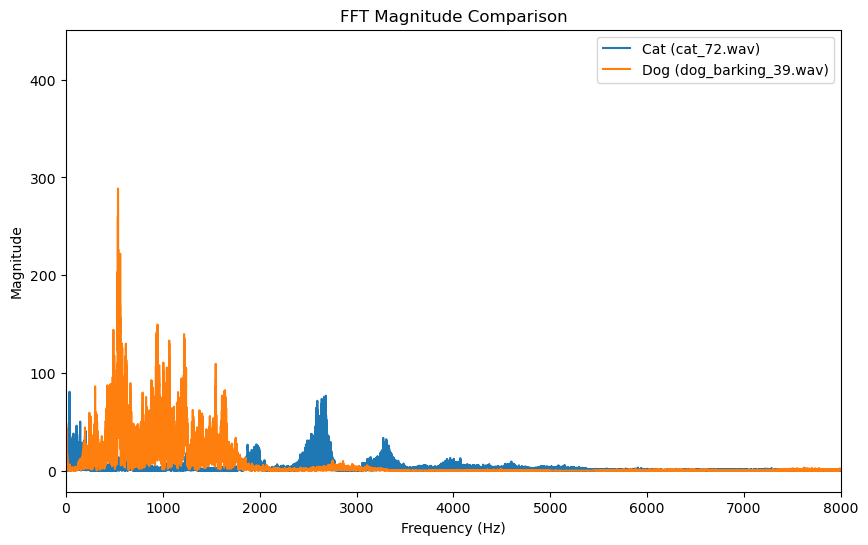

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(freq_cat, np.abs(Y_cat), label=f'Cat ({os.path.basename(cat_sample)})')
plt.plot(freq_dog, np.abs(Y_dog), label=f'Dog ({os.path.basename(dog_sample)})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT Magnitude Comparison')
plt.legend()
plt.xlim(0, min(fs_cat, fs_dog) / 2)
plt.show()

In [11]:
all_cat_mags = []
all_dog_mags = []
min_len = None

for fname in cat_files:
    fs, data = wavfile.read(os.path.join(cat_dir, fname))
    if data.ndim > 1:
        data = data[:, 0]
    dt = 1 / fs
    _, Y = sp.compute_fft(data, dt)
    mag = np.abs(Y)
    all_cat_mags.append(mag)
    if min_len is None or len(mag) < min_len:
        min_len = len(mag)


In [12]:
for fname in dog_files:
    fs, data = wavfile.read(os.path.join(dog_dir, fname))
    if data.ndim > 1:
        data = data[:, 0]
    dt = 1 / fs
    _, Y = sp.compute_fft(data, dt)
    mag = np.abs(Y)
    all_dog_mags.append(mag)
    if len(mag) < min_len:
        min_len = len(mag)

In [13]:
freqs = np.linspace(0, fs/2, min_len)  # fs는 마지막에 읽었던 샘플링 주파수(frequency)
cat_stack = np.vstack([m[:min_len] for m in all_cat_mags])
dog_stack = np.vstack([m[:min_len] for m in all_dog_mags])
mean_cat = cat_stack.mean(axis=0)
mean_dog = dog_stack.mean(axis=0)

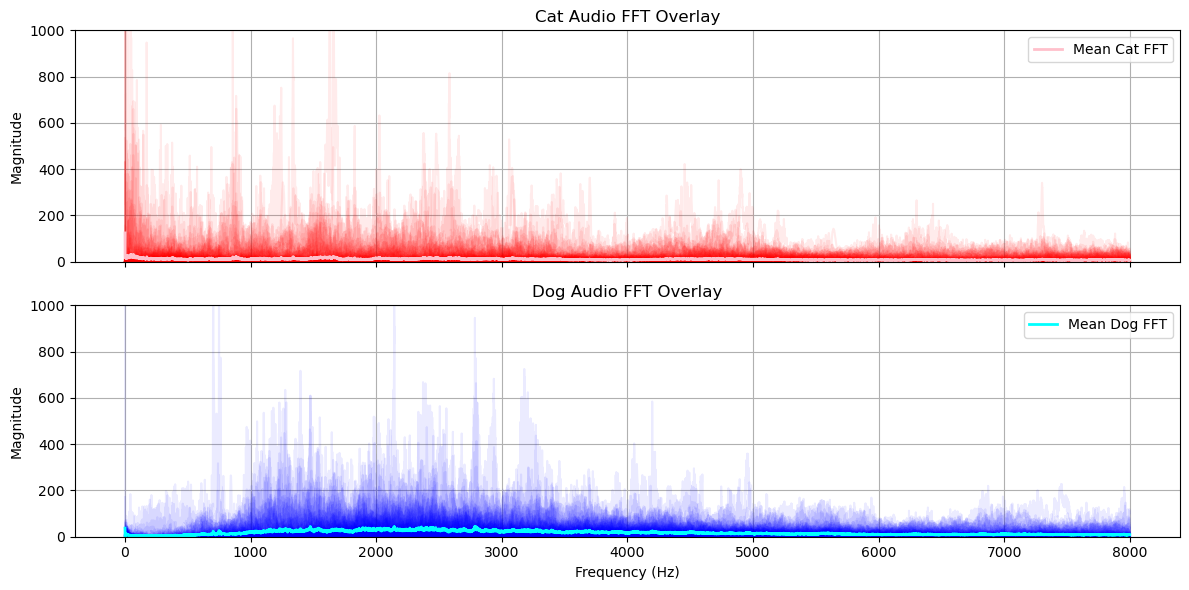

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for m in cat_stack:
    axes[0].plot(freqs, m, color='red', alpha=0.08)
axes[0].plot(freqs, mean_cat, color='pink', linewidth=2, label='Mean Cat FFT')
axes[0].set_title('Cat Audio FFT Overlay')
axes[0].set_ylim([0, 1000])
axes[0].set_ylabel('Magnitude')
axes[0].legend()
axes[0].grid(True)

for m in dog_stack:
    axes[1].plot(freqs, m, color='blue', alpha=0.08)
axes[1].plot(freqs, mean_dog, color='cyan', linewidth=2, label='Mean Dog FFT')
axes[1].set_title('Dog Audio FFT Overlay')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_ylim([0, 1000])
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [15]:
cat_dir = 'cat'
dog_dir = 'dog'
labels_map = {'cat': 0, 'dog': 1}

file_paths = []
labels = []
for cls, label in labels_map.items():
    cls_dir = cls  # 'cat' 또는 'dog'
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith('.wav'):
            file_paths.append(os.path.join(cls_dir, fname))
            labels.append(label)

In [16]:
def extract_fft_features(path):
    fs, data = wavfile.read(path)
    if data.ndim > 1:
        data = data[:, 0]
    dt = 1 / fs
    _, Y = sp.compute_fft(data, dt)
    return np.abs(Y)

In [17]:
features = [extract_fft_features(p) for p in file_paths]
min_len = min(len(fv) for fv in features)
X = np.array([fv[:min_len] for fv in features])
y = np.array(labels)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=13, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [19]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=13)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=13)

In [20]:
train_acc = clf.score(X_train_scaled, y_train)
test_acc  = clf.score(X_test_scaled,  y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

Train accuracy: 1.0000
Test accuracy:  0.7857


In [21]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['cat', 'dog']))

              precision    recall  f1-score   support

         cat       0.86      0.76      0.81        25
         dog       0.70      0.82      0.76        17

    accuracy                           0.79        42
   macro avg       0.78      0.79      0.78        42
weighted avg       0.80      0.79      0.79        42



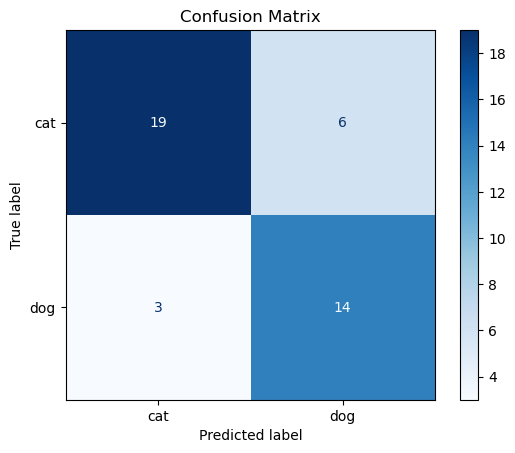

In [22]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=['cat', 'dog'], cmap=plt.cm.Blues
)
plt.title('Confusion Matrix')
plt.show()